<a href="https://colab.research.google.com/github/j3nguyen/user_item_embeddings/blob/master/NextAction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting User Journeys

In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
# import gensim
# import gensim.corpora as corpora
# from gensim.utils import simple_preprocess
# from gensim.models import CoherenceModel

# spacy for lemmatization
# import spacy

# NLTK for stopwords and stemming
# from nltk.stem.porter import * 
# from nltk.stem.snowball import SnowballStemmer
# from nltk.corpus import stopwords
# stop_words = stopwords.words('english')

# Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib
import pickle
import bz2

In [2]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dense, Average, Dropout, Embedding, Activation, TimeDistributed, Concatenate, Flatten, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Read in the data

Rearrange the data so each row is one user and his sequence of actions

In [7]:
df = pd.read_csv("events.csv")

#sort the dataframe by time
df.sort_values(by="timestamp", inplace=True)
df.head()

,timestamp,visitorid,event,itemid,transactionid
1462974,1430622004384,693516,addtocart,297662,NaN
1464806,1430622011289,829044,view,60987,NaN
1463000,1430622013048,652699,view,252860,NaN
1465287,1430622024154,1125936,view,33661,NaN
1462955,1430622026228,693516,view,297662,NaN


In [8]:
# get all the visitor_ids
visitor_ids = df.visitorid.unique()

print("There are {} users".format(len(visitor_ids)))

There are 1407580 users


In [9]:
# inspect action distribution
df.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [0]:
# encode actions to numbers
action_to_idx = {"view": 0, "addtocart": 1, "transaction": 2}

In [0]:
visitor_activity = pickle.load(bz2.BZ2File('visitor_activity.pkl', 'r'))

In [0]:
# creating dictionary of visitor sequence of activity
visitor_activity = {}

for visitor in visitor_ids:
  # get user's actions in order of time
  actions = df[df.visitorid == visitor].event.values
  
  if len(actions) > 50:
    # get the first 51 actions
    actions = list(map(lambda x: action_to_idx[x],actions)) [:51] 
    visitor_activity[visitor] = actions

In [0]:
hidden_size = 64 #dimension of action vectors
num_actions = len(action_to_idx) #dictionary size
input_length = 50 # number of actions in sequence
num_users = len(visitor_activity)

In [6]:
num_users

1225

#### Create user sessions

Here we're splitting user's actions into separate sessions so that we can predict their next action

In [0]:
#30 mins in miliseconds 
session_expire = 60*30*1000

visitor_sessions = {}

for visitor in visitor_ids[:100000]:
    # calculate time deltas between actions
    time_delta = df[df.visitorid == visitor].timestamp.diff()
    actions = df[df.visitorid == visitor].event.values

    if len(actions) > 1:
      # split actions into sessions, where a session ends after session_expire
      all_sessions = np.split(actions,np.where(time_delta >= session_expire)[0])

      # sessions with more than one action
      filtered_sessions = list(filter(lambda x: len(x) > 1, all_sessions))

      if len(filtered_sessions) > 0:
        visitor_sessions[visitor] = list(map(lambda x: list(map(lambda y: action_to_idx[y],x)) ,filtered_sessions))


In [0]:
visitor_sessions = pickle.load(bz2.BZ2File('visitor_sessions.pkl', 'r'))

In [11]:
sum(map(len,visitor_sessions.values()))/len(visitor_sessions)

1.555572839698219

In [0]:
# pickle.dump( visitor_sessions, bz2.BZ2File('/content/drive/My Drive/Colab Notebooks/visitor_sessions.pkl', 'w') )

In [0]:
pickle.dump(visitor_activity, bz2.BZ2File('/content/drive/My Drive/Colab Notebooks/visitor_activity.pkl','w'))

#### Create the training data and labels

Here, we're holding out the 51st action as the label

In [0]:
actions = visitor_activity.values()
d = np.array(range(len(actions))) # users
X = np.array(list(map(lambda x: x[:-1], actions))) #actions for each user
y = to_categorical(np.array(list(map(lambda x: x[50], actions))), num_classes=3) # shift sequence on step forward
# X_3d = X.reshape((X.shape[0],X.shape[1],1))

In [0]:
ts = np.array(list(actions))
X_ts = []
y_ts = []

timesteps = 10

for i in range(num_users):
  for j in range(len(ts[i])):
    x_start_idx = j
    y_start_idx = x_start_idx + 1

    x_end_idx = x_start_idx + timesteps
    y_end_idx = y_start_idx + timesteps

    # print(x_start_idx, x_end_idx, y_start_idx, y_end_idx)
    #get a sequence of timesteps actions
    if y_end_idx <= len(ts[i]):
      x_input = ts[i,x_start_idx:x_end_idx]
      # y_output = ts[i,y_start_idx:y_end_idx]
      y_output = to_categorical(ts[i,y_start_idx:y_end_idx], num_classes=3)
      X_ts.append(x_input)
      y_ts.append(y_output)
    

In [9]:
X_ts = np.array(X_ts)
y_ts = np.array(y_ts)

print(X_ts.shape)
print(y_ts.shape)

(50225, 10)
(50225, 10, 3)


Reformatting the data to one session per row

In [0]:
sessions = visitor_sessions.values()
sessions_flat = [item for sublist in sessions for item in sublist]

In [48]:
# assigning user_ids to each session
d = [[i]*len(visitor_sessions[user_id]) for i, user_id in zip(range(len(sessions)),visitor_sessions.keys())]
d = np.array([item for sublist in d for item in sublist])

X = np.array(list(map(lambda x: np.array(x[:-1]), sessions_flat)))
y = to_categorical(np.array(list(map(lambda x: x[-1], sessions_flat))),num_classes=3)
num_users = len(visitor_sessions)
print(X.shape)
print(y.shape)

(40000,)
(40000, 3)


In [0]:
from keras.utils import Sequence
class MyBatchGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, X, d, y, batch_size=1, shuffle=True):
        'Initialization'
        self.X = X
        self.y = y
        self.d = d
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.y)/self.batch_size))

    def __getitem__(self, index):
        return self.__data_generation(index)

    def on_epoch_end(self):
        'Shuffles indexes after each epoch'
        self.indexes = np.arange(len(self.y))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, index):
        Xb = np.empty((self.batch_size, *X[index].shape))
        yb = np.empty((self.batch_size, *y[index].shape))
        db = np.empty((self.batch_size, *d[index].shape))
        # naively use the same sample over and over again
        for s in range(0, self.batch_size):
            Xb[s] = X[index]
            yb[s] = y[index]
            db[s] = d[index]
        return [Xb, db], yb

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, d_train, d_test, y_train, y_test = train_test_split(X,d,y, test_size = 0.2, random_state=342,stratify=y)

In [0]:
X_ts_train, X_ts_test, y_ts_train, y_ts_test = train_test_split(X_ts,y_ts, test_size = 0.2, random_state=342)

In [0]:
X_train, X_test,d_train, d_test,y_train, y_test = train_test_split(X,d,y, test_size = 0.2, random_state=342,stratify=y)

In [0]:
X_train, X_val,d_train,d_val,y_train, y_val = train_test_split(X_train,d_train,y_train, test_size = 0.2, random_state=342,stratify=y_train)

## Build the models

### Using the Sequential API

In [37]:
#create the LSTM network

# sequence of actions
A = Input(shape=(timesteps,), name="actions") #length of sequence, size of vocab

#create embedding for actions and for users
a = Embedding(input_dim=num_actions, output_dim=hidden_size, input_length=timesteps, name='action_embedding')(A) # shape 50,64

L = LSTM(hidden_size,return_sequences=True)(a)

predictions = TimeDistributed(Dense(num_actions, activation='softmax'))(L)
predictions = Activation('softmax')(predictions)

model4 = Model(inputs=A, outputs=predictions)
model4.summary()


# model4 = Sequential()
# model4.add(Embedding(num_actions, hidden_size, input_length=10, name='action_embedding'))
# # model4.add(LSTM(hidden_size, return_sequences=True))
# model4.add(LSTM(hidden_size, return_sequences=True))

# # model4.add(Dropout(rate=0.5))
# model4.add(TimeDistributed(Dense(num_actions)))
# model4.add(Activation('softmax'))
# # model4.add(Dense(num_actions, activation='softmax'))

# model4.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
actions (InputLayer)         (None, 10)                0         
_________________________________________________________________
action_embedding (Embedding) (None, 10, 64)            192       
_________________________________________________________________
lstm_9 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 3)             195       
_________________________________________________________________
activation_3 (Activation)    (None, 10, 3)             0         
Total params: 33,411
Trainable params: 33,411
Non-trainable params: 0
_________________________________________________________________


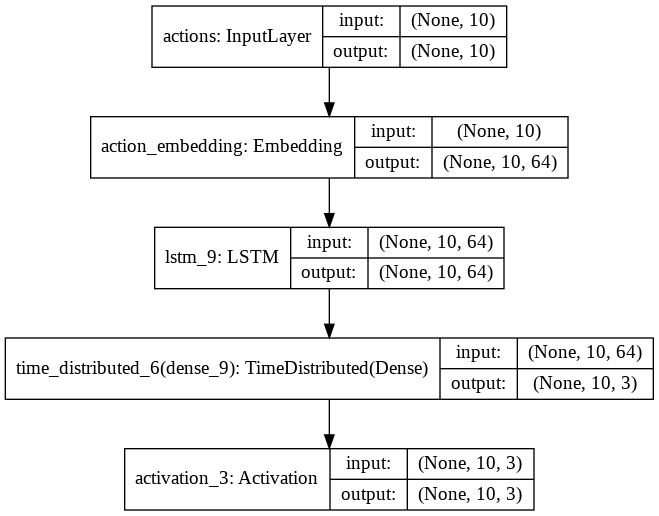

In [38]:
plot_model(model4, show_shapes=True, show_layer_names=True)

In [0]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)

model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [40]:
h = model4.fit(X_ts_train, y_ts_train, epochs=50, batch_size=128, validation_split=0.1, verbose=1)

Train on 36162 samples, validate on 4018 samples
Epoch 1/50
36162/36162 [==============================] - 8s 210us/step - loss: 0.6876 - acc: 0.9139 - val_loss: 0.6396 - val_acc: 0.9169
Epoch 2/50
36162/36162 [==============================] - 6s 170us/step - loss: 0.6371 - acc: 0.9170 - val_loss: 0.6359 - val_acc: 0.9169
Epoch 3/50
36162/36162 [==============================] - 6s 167us/step - loss: 0.6354 - acc: 0.9170 - val_loss: 0.6352 - val_acc: 0.9169
Epoch 4/50
36162/36162 [==============================] - 6s 172us/step - loss: 0.6350 - acc: 0.9170 - val_loss: 0.6350 - val_acc: 0.9169
Epoch 5/50
36162/36162 [==============================] - 6s 159us/step - loss: 0.6348 - acc: 0.9170 - val_loss: 0.6349 - val_acc: 0.9169
Epoch 6/50
36162/36162 [==============================] - 6s 163us/step - loss: 0.6347 - acc: 0.9170 - val_loss: 0.6348 - val_acc: 0.9169
Epoch 7/50
36162/36162 [==============================] - 6s 164us/step - loss: 0.6346 - acc: 0.9170 - val_loss: 0.6347 - v

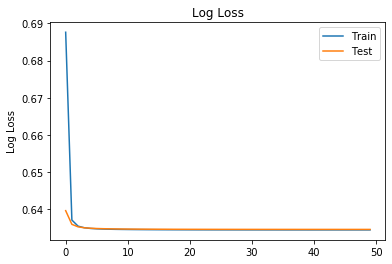

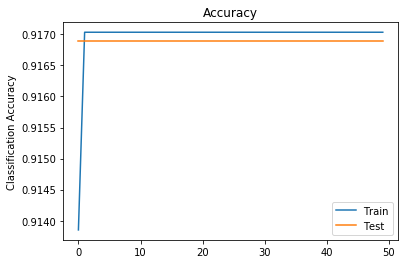

In [41]:
results = h.history
epochs = len(results['val_loss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['loss'], label='Train')
ax.plot(x_axis, results['val_loss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('Log Loss')
plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['acc'], label='Train')
ax.plot(x_axis, results['val_acc'], label='Test')
ax.legend()
plt.ylabel('Classification Accuracy')
plt.title('Accuracy')
plt.show()

### Using the Keras functional API

We treat each user action like a word. In this data set, there are three types of actions:


* view
* add to cart
* transaction

Therefore, the size of the vocabulary is 3. A user's sequence of actions, or her journey, is liken to a sentence/paragraph.

We want to embed these actions into vectors as well as the user's journey to help predict the next action. 

#### Model 1
The first model will embed the actions and user's journey to help predict the next action. This is similar to a multi-class classification problem.



In [0]:
## helper functions for doc2vec algorithm
def my_split(window_size):
    def _lambda(tensor):
        import tensorflow as tf
        return tf.split(tensor, window_size + 1, axis=1)
    return _lambda


def squeeze(axis=-1):
    def _lambda(tensor):
        import tensorflow as tf
        return tf.squeeze(tensor, axis=axis)
    return _lambda


def stack(window_size):
    def _lambda(tensor):
        import tensorflow as tf
        return tf.stack([tensor] * window_size, axis=1)
    return _lambda

In [0]:
num_users = X_train.shape[0]
user_id_mappings = {i:user_id for user_id,i in zip(d_train,range(num_users))}
d_train_ids = np.array(list(user_id_mappings.keys()))

In [40]:
#Create the LSTM  network using the functional API

# sequence of actions
A = Input(shape=(input_length,), name="actions") #length of sequence, size of vocab

# document ID
U = Input(shape=(1,), name="users")

#create embedding for actions and for users
a = Embedding(input_dim=num_actions, output_dim=hidden_size, input_length=input_length, name='action_embedding')(A) # shape 50,64
u = Embedding(input_dim=num_users, output_dim=hidden_size, input_length=1, name='user_embedding')(U) # shape 1,64

# combine embeddings
x = Concatenate(axis=1)([u,a])

split = Lambda(my_split(input_length))(x)
averaged = Average()(split)
squeezed = Lambda(squeeze(axis=1))(averaged)

predictions = Dense(num_actions, activation='softmax')(squeezed)

model = Model(inputs=[U,A], outputs=predictions)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
actions (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 64)        78400       users[0][0]                      
__________________________________________________________________________________________________
action_embedding (Embedding)    (None, 50, 64)       192         actions[0][0]                    
____________________________________________________________________________________________

In [0]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
h = model.fit([d_train,X_train], y_train, epochs=50, batch_size=128, validation_split=0.1, verbose=1,  class_weight={0:0.1, 1: 0.3, 2:0.6})

Train on 882 samples, validate on 98 samples
Epoch 1/50
882/882 [==============================] - 1s 887us/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.0728 - val_acc: 0.9286
Epoch 2/50
882/882 [==============================] - 0s 54us/step - loss: 0.0098 - acc: 1.0000 - val_loss: 0.0725 - val_acc: 0.9388
Epoch 3/50
882/882 [==============================] - 0s 46us/step - loss: 0.0097 - acc: 1.0000 - val_loss: 0.0724 - val_acc: 0.9388
Epoch 4/50
882/882 [==============================] - 0s 46us/step - loss: 0.0096 - acc: 1.0000 - val_loss: 0.0725 - val_acc: 0.9388
Epoch 5/50
882/882 [==============================] - 0s 46us/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.0726 - val_acc: 0.9388
Epoch 6/50
882/882 [==============================] - 0s 47us/step - loss: 0.0094 - acc: 1.0000 - val_loss: 0.0726 - val_acc: 0.9388
Epoch 7/50
882/882 [==============================] - 0s 44us/step - loss: 0.0094 - acc: 1.0000 - val_loss: 0.0727 - val_acc: 0.9388
Epoch 8/50
882/882 [===

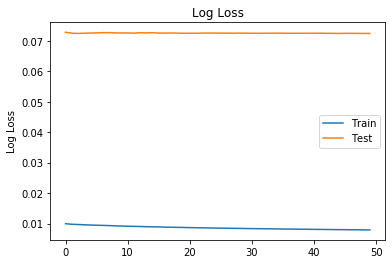

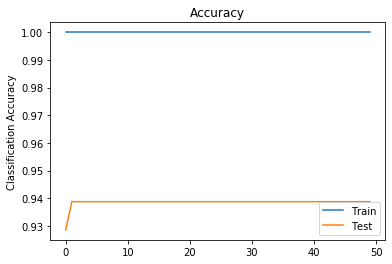

In [86]:
results = h.history
epochs = len(results['val_loss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['loss'], label='Train')
ax.plot(x_axis, results['val_loss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('Log Loss')
plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['acc'], label='Train')
ax.plot(x_axis, results['val_acc'], label='Test')
ax.legend()
plt.ylabel('Classification Accuracy')
plt.title('Accuracy')
plt.show()

#### Model 2
The second model is an RNN which will take into account the sequence of actions to predict the next action.

In [90]:
#Create the NN network using the functional API

# sequence of actions
A = Input(shape=(input_length,), name="actions") #length of sequence, size of vocab

# document ID
U = Input(shape=(1,), name="users")

#create embedding for actions and for users
a = Embedding(input_dim=num_actions, output_dim=hidden_size, input_length=input_length, name='action_embedding')(A) # shape 50,64
u = Embedding(input_dim=num_users, output_dim=hidden_size, input_length=1, name='user_embedding')(U) # shape 1,64

# combine embeddings
x = Concatenate(axis=1)([u,a])

L = LSTM(hidden_size,return_sequences=False)(x)

predictions = Dense(num_actions, activation='softmax')(L)

model2 = Model(inputs=[U,A], outputs=predictions)
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
actions (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 64)        78400       users[0][0]                      
__________________________________________________________________________________________________
action_embedding (Embedding)    (None, 50, 64)       192         actions[0][0]                    
____________________________________________________________________________________________

In [0]:
# create the optimizer
opt2 = Adam(lr=0.1, beta_1=0.9, beta_2=0.999)

model2.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])

In [92]:
h2 = model2.fit([d_train,X_train], y_train, epochs=50, batch_size=128, class_weight={0:0.1, 1: 0.3, 2:0.6}, validation_split=0.1, verbose=1)

Train on 882 samples, validate on 98 samples
Epoch 1/50
882/882 [==============================] - 2s 2ms/step - loss: 0.1531 - acc: 0.7834 - val_loss: 0.0911 - val_acc: 0.8980
Epoch 2/50
882/882 [==============================] - 1s 706us/step - loss: 0.0725 - acc: 0.8776 - val_loss: 0.0692 - val_acc: 0.9184
Epoch 3/50
882/882 [==============================] - 1s 642us/step - loss: 0.0620 - acc: 0.8889 - val_loss: 0.0554 - val_acc: 0.9286
Epoch 4/50
882/882 [==============================] - 1s 633us/step - loss: 0.0569 - acc: 0.8980 - val_loss: 0.0550 - val_acc: 0.9082
Epoch 5/50
882/882 [==============================] - 1s 629us/step - loss: 0.0559 - acc: 0.8889 - val_loss: 0.0597 - val_acc: 0.9184
Epoch 6/50
882/882 [==============================] - 1s 672us/step - loss: 0.0534 - acc: 0.8946 - val_loss: 0.0527 - val_acc: 0.9286
Epoch 7/50
882/882 [==============================] - 1s 681us/step - loss: 0.0548 - acc: 0.8912 - val_loss: 0.0556 - val_acc: 0.9184
Epoch 8/50
882/882 

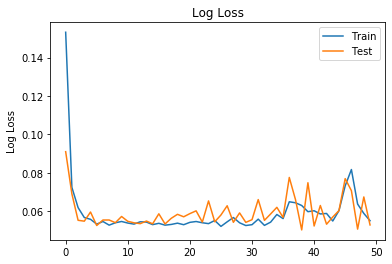

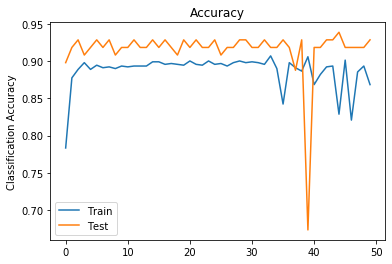

In [93]:
results = h2.history
epochs = len(results['val_loss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['loss'], label='Train')
ax.plot(x_axis, results['val_loss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('Log Loss')
plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['acc'], label='Train')
ax.plot(x_axis, results['val_acc'], label='Test')
ax.legend()
plt.ylabel('Classification Accuracy')
plt.title('Accuracy')
plt.show()

In [49]:
#Create the NN network using the functional API with return sequences

# sequence of actions
A = Input(shape=(None,), name="actions") #length of sequence, size of vocab

# document ID
U = Input(shape=(1,), name="users")

#create embedding for actions and for users
a = Embedding(input_dim=num_actions, output_dim=hidden_size, name='action_embedding')(A) # shape 50,64
u = Embedding(input_dim=num_users, output_dim=hidden_size, input_length=1, name='user_embedding')(U) # shape 1,64

# combine embeddings
x = Concatenate(axis=1)([u,a])

L = LSTM(hidden_size,return_sequences=False)(x)

predictions = Dense(num_actions, activation='softmax')(L)

model3 = Model(inputs=[A,U], outputs=predictions)
model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
actions (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 64)        1645696     users[0][0]                      
__________________________________________________________________________________________________
action_embedding (Embedding)    (None, None, 64)     192         actions[0][0]                    
____________________________________________________________________________________________

In [56]:
# create the optimizer
opt3 = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, decay=0.01)

model3.compile(optimizer=opt3, loss='categorical_crossentropy', metrics=['accuracy'])

h3 = model3.fit_generator(MyBatchGenerator(X_train,d_train,y_train),validation_data=MyBatchGenerator(X_val,d_val,y_val), class_weight={0:0.20, 1: 0.3, 2:0.5}, epochs=8, verbose=1)

Epoch 1/8
25600/25600 [==============================] - 790s 31ms/step - loss: 0.0591 - acc: 0.9293 - val_loss: 0.1660 - val_acc: 0.9428
Epoch 2/8
25600/25600 [==============================] - 778s 30ms/step - loss: 0.0510 - acc: 0.9366 - val_loss: 0.1551 - val_acc: 0.9428
Epoch 3/8
25600/25600 [==============================] - 796s 31ms/step - loss: 0.0487 - acc: 0.9384 - val_loss: 0.1501 - val_acc: 0.9456
Epoch 4/8
25600/25600 [==============================] - 772s 30ms/step - loss: 0.0474 - acc: 0.9406 - val_loss: 0.1467 - val_acc: 0.9461
Epoch 5/8
25600/25600 [==============================] - 768s 30ms/step - loss: 0.0465 - acc: 0.9415 - val_loss: 0.1444 - val_acc: 0.9467
Epoch 6/8
25600/25600 [==============================] - 747s 29ms/step - loss: 0.0459 - acc: 0.9422 - val_loss: 0.1425 - val_acc: 0.9473
Epoch 7/8
25600/25600 [==============================] - 765s 30ms/step - loss: 0.0454 - acc: 0.9426 - val_loss: 0.1413 - val_acc: 0.9472
Epoch 8/8
25600/25600 [===========

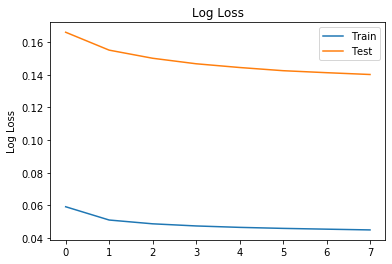

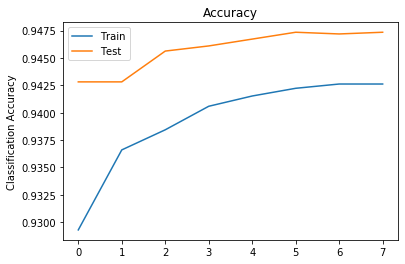

In [57]:
results = h3.history
epochs = len(results['val_loss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['loss'], label='Train')
ax.plot(x_axis, results['val_loss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('Log Loss')
plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['acc'], label='Train')
ax.plot(x_axis, results['val_acc'], label='Test')
ax.legend()
plt.ylabel('Classification Accuracy')
plt.title('Accuracy')
plt.show()

## Evaluate models

#### helper functions

In [0]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_auc_score, roc_curve
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
y_true = np.argmax(y_test,axis=1)

In [0]:
## Model 1 predictions
pred_prob = model.predict([d_test,X_test])
y_pred = np.argmax(pred_prob,axis=1)

In [0]:
## Model 2 predictions
pred_prob2 = model2.predict([d_test,X_test])
y_pred2 = np.argmax(pred_prob2,axis=1)

In [0]:
## Model 3 predictions
pred_prob3 = model3.predict_generator(MyBatchGenerator(X_test,d_test,y_test))
y_pred3 = np.argmax(pred_prob3,axis=1)

In [0]:
## Model 4 predictions
pred_prob4 = model4.predict(X_ts_test)
# pred_prob4[0]
y_pred4 = np.argmax(pred_prob4,axis=2)
y_ts_test_labels = np.argmax(y_ts_test,axis=2)

Confusion matrix, without normalization
[[215   5   3]
 [ 11   2   2]
 [  5   1   1]]


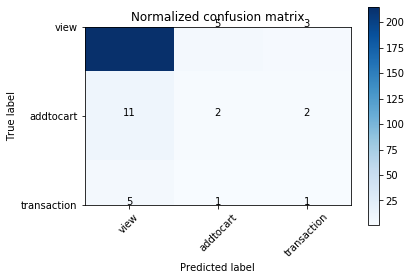

In [88]:
conf=confusion_matrix(y_true,y_pred)
plt.figure()
plot_confusion_matrix(conf, classes=action_to_idx.keys(), normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

Confusion matrix, without normalization
[[215   1   7]
 [  8   6   1]
 [  3   0   4]]


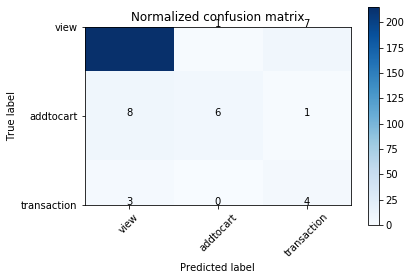

In [95]:
conf2=confusion_matrix(y_true,y_pred2)
plt.figure()
plot_confusion_matrix(conf2, classes=action_to_idx.keys(), normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

Confusion matrix, without normalization
[[6986  146  327]
 [ 294   11   13]
 [ 210    2   11]]


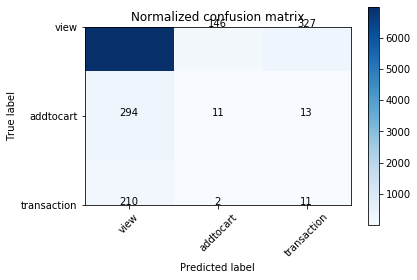

In [59]:
conf3=confusion_matrix(y_true,y_pred3)
plt.figure()
plot_confusion_matrix(conf3, classes=action_to_idx.keys(), normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

Confusion matrix, without normalization
[[91772   428    59]
 [ 5657   991    10]
 [ 1419    34    80]]


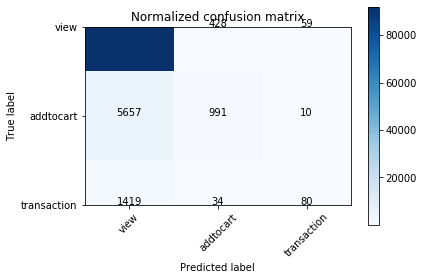

In [34]:
#new shape
num_instances = y_pred4.shape[0]*y_pred4.shape[1]

conf4=confusion_matrix(y_ts_test_labels.reshape((num_instances,)),y_pred4.reshape((num_instances,)))
plt.figure()
plot_confusion_matrix(conf4, classes=action_to_idx.keys(), normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

In [96]:
print(classification_report(y_true,y_pred,target_names=action_to_idx.keys()))
print(classification_report(y_true,y_pred2,target_names=action_to_idx.keys()))

              precision    recall  f1-score   support

        view       0.93      0.96      0.95       223
   addtocart       0.25      0.13      0.17        15
 transaction       0.17      0.14      0.15         7

    accuracy                           0.89       245
   macro avg       0.45      0.41      0.42       245
weighted avg       0.87      0.89      0.88       245

              precision    recall  f1-score   support

        view       0.95      0.96      0.96       223
   addtocart       0.86      0.40      0.55        15
 transaction       0.33      0.57      0.42         7

    accuracy                           0.92       245
   macro avg       0.71      0.65      0.64       245
weighted avg       0.93      0.92      0.92       245



In [60]:
print(classification_report(y_true,y_pred3,target_names=action_to_idx.keys()))

              precision    recall  f1-score   support

        view       0.93      0.94      0.93      7459
   addtocart       0.07      0.03      0.05       318
 transaction       0.03      0.05      0.04       223

    accuracy                           0.88      8000
   macro avg       0.34      0.34      0.34      8000
weighted avg       0.87      0.88      0.87      8000



In [35]:
print(classification_report(y_ts_test_labels.reshape((num_instances,)),y_pred4.reshape((num_instances,)),target_names=action_to_idx.keys()))

              precision    recall  f1-score   support

        view       0.93      0.99      0.96     92259
   addtocart       0.68      0.15      0.24      6658
 transaction       0.54      0.05      0.10      1533

    accuracy                           0.92    100450
   macro avg       0.72      0.40      0.43    100450
weighted avg       0.91      0.92      0.90    100450



## Visualize User Journey Embeddings

Get the embeddings from the network

In [0]:
## embeddings for doc2vec model
embeddings = model.get_layer(name='user_embedding')
embeddings = embeddings.get_weights()[0]
embeddings = embeddings / np.linalg.norm(embeddings, axis = 1).reshape((-1, 1))
embeddings = np.nan_to_num(embeddings)

In [0]:
## Embeddings for RNN model
embeddings2 = model2.get_layer(name='user_embedding')
embeddings2 = embeddings2.get_weights()[0]
embeddings2 = embeddings2 / np.linalg.norm(embeddings2, axis = 1).reshape((-1, 1))
embeddings2 = np.nan_to_num(embeddings2)

In [0]:
## Embeddings for variable length RNN model
embeddings3 = model3.get_layer(name='user_embedding')
embeddings3 = embeddings3.get_weights()[0]
embeddings3 = embeddings3 / np.linalg.norm(embeddings3, axis = 1).reshape((-1, 1))
embeddings3 = np.nan_to_num(embeddings3)

### Use tSNE to visualize the embeddings

To visualize each user's vector, we reduce it to two dimensions using tSNE and colour code them with the 51st action

In [0]:
from sklearn.manifold import TSNE


In [0]:
y_true = np.argmax(y,axis=1)

In [0]:
## Embeddings for doc2vec model
tsne = TSNE(n_components=2, init='pca', random_state=0)
embeddings_reduced = tsne.fit_transform(embeddings)

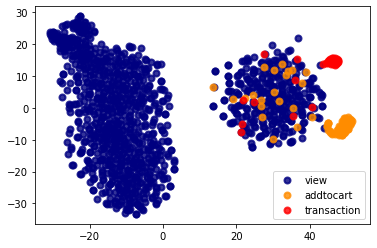

In [38]:
plt.figure()
colors = ['navy', 'darkorange', 'red']
lw = 2
target_names = action_to_idx.keys()

#original points
for color, i, target_name in zip(colors, [0, 1,2], target_names):
    plt.scatter(embeddings_reduced[y_true == i, 0], embeddings_reduced[y_true == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

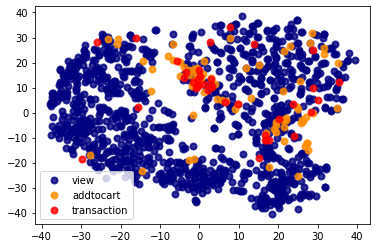

In [39]:
embeddings_reduced2 = tsne.fit_transform(embeddings2)
plt.figure()
colors = ['navy', 'darkorange', 'red']
lw = 2
target_names = action_to_idx.keys()

#original points
for color, i, target_name in zip(colors, [0, 1,2], target_names):
    plt.scatter(embeddings_reduced2[y_true == i, 0], embeddings_reduced2[y_true == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

In [0]:
embeddings_reduced3 = tsne.fit_transform(embeddings3)
plt.figure()
colors = ['navy', 'darkorange', 'red']
lw = 2
target_names = action_to_idx.keys()

#original points
for color, i, target_name in zip(colors, [0, 1,2], target_names):
    plt.scatter(embeddings_reduced3[y_true == i, 0], embeddings_reduced3[y_true == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

IndexError: ignored

<Figure size 432x288 with 0 Axes>

No handles with labels found to put in legend.


(25714, 2)

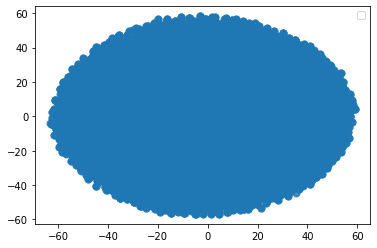

In [0]:
y_true = np.argmax(y,axis=1)
# for color, i, target_name in zip(colors, [0, 1,2], target_names):
plt.scatter(embeddings_reduced3[:, 0], embeddings_reduced3[:, 1], alpha=.8, lw=lw)
plt.legend(loc='best', shadow=False, scatterpoints=1)

embeddings_reduced3.shape

In [0]:
pickle.dump( visitor_sessions, bz2.BZ2File('visitor_sessions.pkl', 'w') )
pickle.dump( embeddings3, bz2.BZ2File('embeddings3.pkl', 'w') )

To Dos


*   [ ] visualize sequence of user actions
*   [x] create proper train and test sets
*   [ ] incorporate item features into model
* [x] check LSTM is embedding users correctly
     * [x] create data set by user sessions
* [x] are new users embedded correctly?
    * only 'in vocabulary' users are embedded, to predict new users's actions, you'd have to find their neighbours
* [ ] predict next steps

learn the embeddings, use the embeddings to predict in a separate model

or learn the embeddings in the same model






